In [1]:
import numpy as np
import lightgbm as lgb
import os
import pandas as pd
import sklearn
from hyperopt import fmin, tpe, hp, partial, Trials, STATUS_OK
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, zero_one_loss
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
# import graphviz
# import shap
import lightgbm as lgb
import time
from math import sqrt
import re
import os
import math
import pickle
from sklearn.metrics import mean_squared_error, zero_one_loss,mean_absolute_error,r2_score
from random import sample
import pylab as plt
#from PyEMD import EMD

In [2]:
def CalGain(listL, listR, firstG, secondG, Lambda, gamma):
    """calculater Gain for histogram"""
    GL = firstG[listL].sum()
    GR = firstG[listR].sum()
    HL = secondG[listL].sum()
    HR = secondG[listR].sum()
    return (GL ** 2 / (HL + Lambda) + GR ** 2 / (HR + Lambda) - (GR + GL) ** 2 / (
                HL + HR + Lambda)) / 2 - gamma

def getListMaxNumIndex(num_list,topk=3):
    num_dict={}
    for i in range(len(num_list)):
        num_dict[i]=num_list[i]
    res_list=sorted(num_dict.items(),key=lambda e:e[1])
    max_num_index=[one[0] for one in res_list[::-1][:topk]]
    #min_num_index=[one[0] for one in res_list[:topk]]
    #print ('max_num_index:',max_num_index)
    #print ('min_num_index:',min_num_index)
    return max_num_index

def find_split_worker(x_train, g, h, indexlist, k, bins, Lambda, gamma):
    topKsplit = []
    topKgain = []
    # print(len(X_train))
    # x_all_set=self.client.gather(x_train)
    # x_train=np.concatenate(x_train, axis=0)
    firstG = None
    secondG = None
    #             indexlist=self.client.gather(indexlist)
    #             g=self.client.gather(self.firstG)
    #             #print("data shape is:",x_train.shape)
    firstG = g[indexlist]
    secondG = h[indexlist]
    #             for i in range(len(g)):
    # #                 print(g[i].shape)
    # #                 print(indexlist[i].shape)
    #                 firstG.append(g[i][indexlist[i]])
    #             #print(firstG)
    #             #print(len(firstG))
    #             firstG=np.concatenate(firstG, axis=0)
    #             #print('d dggg',firstG.shape)
    #             h=self.client.gather(self.secondG)

    #             for i in range(len(h)):
    #                 secondG.append(h[i][indexlist[i]])
    #             secondG=np.concatenate(secondG, axis=0)
    for feature in range(x_train.shape[1]):
        bestGain = 0
        bestSplitValue = -1
        AllValue = sorted(set(x_train[:, feature]))
        if len(AllValue) > bins:
            try:
                ValueSet = sample(AllValue, bins)
            except:
                print("length of Allvalue is :", len(AllValue))
                print("length of self.bins is :", bins)
        else:
            ValueSet = AllValue
        #                         valueSet=[150]
        # print(ValueSet)
        for Val in ValueSet:
            boolindexLeft = x_train[:, feature] <= Val
            boolindexRight = ~boolindexLeft
            #                         indexLeft = indexlist[boolindexLeft]
            #                         indexRight = indexlist[boolindexRight]
            indexLeft = boolindexLeft
            indexRight = boolindexRight
            # print('left is:', firstG[indexLeft].shape)
            # print('right index is',firstG[indexRight].shape)
            gain = CalGain(indexLeft, indexRight, firstG, secondG, Lambda, gamma)
            if gain > bestGain:
                bestGain = gain
                #                         bestSplitFeature=feature
                bestSplitValue = Val
        topKsplit.append({feature: bestSplitValue})
        topKgain.append(bestGain)
    index = getListMaxNumIndex(topKgain, topk=k)
    topgainList = []
    topsplitList = []
    for i in index:
        topgainList.append(topKgain[i])
        topsplitList.append(topKsplit[i])
    return topgainList, topsplitList

def EMDpreprocess(dataframe):    
    np_array=np.array(dataframe)
    #inputs=client.compute(x[:,0], worker=worker[0])
#     #inputs=client.compute(x[:,0])
    inputs, targets=np_array[:, 0], np_array[:, 1]
    t=np.array([i for i in range(len(inputs))])
    #IMF = EMD().emd(inputs, max_imf=2)
    #N = IMF.shape[0]+1
    windowsize=99
    offset = int(0.5 * (windowsize - 1.0))
    window_num=inputs.size - 2 * offset
#     IMF=IMF.transpose()
#     print(IMF.shape)
    features=list()
    labels=list()
    for i in range(0,window_num):
        #inp=inputs[i:i+windowsize,:]
        data_in=inputs[i:i+windowsize]
        tar=targets[i+offset]
        #data_in=np.hstack(inp)
        features.append(data_in)
        labels.append(tar)
    X=np.array(features)
    Y=np.array(labels)

    x_train_all, x_predict, y_train_all, y_predict = train_test_split(X, Y, test_size=0.01, random_state=100)
    x_train_all, x_predict, y_train_all, y_predict = train_test_split(x_predict, y_predict, test_size=0.2, random_state=100)
    x_train, x_test, y_train, y_test = train_test_split(x_train_all, y_train_all, test_size=0.2,random_state=100)
    return  x_train, y_train, x_predict, y_predict, x_test,  y_test

In [3]:
#all method/task executed by workers
def getPara(future,i):
    return future[i]


def inithaty(dataSample):
    haty = np.zeros(len(dataSample))
    return haty
#initialise the value of second-order gradients    
def inith(dataSample):
    h = np.ones(len(dataSample)) * 2
    return h
#calculate first-order gradients of samples located at any certain worker   
def calG(y_train, haty):
    """calculate g_i"""
    return -2 * (y_train - haty)

def initf(x_train):
    return np.empty(len(x_train))

def initindex(x_train):
    return np.arange(x_train.shape[0])

#calculate f of current tree
def assignf(indexlist, f, w):
    f[indexlist]=w
    return True

def newNode(x_train, y_train, indexlist, bestSplitFeature, bestSplitValue):
    left_index = x_train[:, bestSplitFeature] <= bestSplitValue
    sub_X_train_left, sub_y_train_left = x_train[left_index], y_train[left_index]
    sub_X_train_right, sub_y_train_right = x_train[~left_index], y_train[~left_index]
    indexlist_left = indexlist[left_index]
    indexlist_right = indexlist[~left_index]
    return sub_X_train_left, sub_y_train_left, sub_X_train_right, sub_y_train_right, indexlist_left, indexlist_right

#update the value of prediction output at current stage
def updateHaty(haty, f, eta):
    updateHaty=haty + eta * f
    return updateHaty

def test(a,b,i):
    return a+b*i

def getLoss_worker(y_train, haty):
    #return mean_absolute_error(y_train, haty)
    return mean_squared_error(y_train, haty, squared=False)

In [5]:
from dask.distributed import wait
class DaskBooster():
    def __init__(self, k, workers, client=None, num_round=50, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae", maxbins=500, maxdepth=10):
        #self.filePath=filePath
        self.client=client
        self.scoring = scoring
        self.num_round = num_round
        self.eta = eta
        self.gamma = gamma
        self.Lambda = Lambda
        self.ensemble = []
        self.firstG= None #first order gradient
        self.secondG = None #second order gradient
        self.haty = None
        self.f = None
        self.indexList=None
        self.workers=workers
        #self.oldTrees=pd.read_csv(self.filePath).groupby(['tree_index'])
        #self.treeIndex=self.oldTrees.size().values.tolist()
        #self.treenum=len(self.treeIndex)
        #self.oldtree=None
        self.bins= maxbins
        self.trace=[]
        self.k=k
        self.depth=maxdepth
        self.worker_trace=[]
        
    def getLoss(self, y_train):
        haty=self.client.gather(self.haty)
        y=self.client.gather(y_train)
        haty=np.concatenate(haty, axis=0)
        y=np.concatenate(y, axis=0)
        return mean_squared_error(y, haty,squared=False), mean_absolute_error(y, haty)
    
    def _G(self, y_train, haty):
        """calculate g_i"""
        return -2 * (y_train - haty)

    def _Gain(self, listL, listR, firstG, secondG):
        """calculater Gain for histogram"""

        GL = firstG[listL].sum()
        GR = firstG[listR].sum()
        HL = secondG[listL].sum()
        HR = secondG[listR].sum()

        return (GL ** 2 / (HL + self.Lambda) + GR ** 2 / (HR + self.Lambda) - (GR + GL) ** 2 / (
                    HL + HR + self.Lambda)) / 2 - self.gamma

    def _w(self, indexlist):
#         return -np.sum(self.g[indexlist]) / (np.sum(self.h[indexlist]) + self.Lambda)
        first=self.client.gather(self.firstG)
        second=self.client.gather(self.secondG)
        indexlist=self.client.gather(indexlist)
        #wait(first)
        #wait(second)
        sumG=0
        sumH=0
        for i in range(len(first)):
            sumG+=np.sum(first[i][indexlist[i]])
            sumH+=np.sum(second[i][indexlist[i]])
        return -sumG/ (sumH+self.Lambda)
        

#     def calWeight(indexlist, firstG, secondG):
#         Lambda=0.7145
#         return -np.sum(firstG[indexlist]) / (np.sum(secondG[indexlist]) + Lambda)

    def BestSplit(self, x_train, indexlist):
        """寻找最佳切分，如果有最佳切分，返回切分特征和切分值;如果无最佳切分，返回None"""
        bestGain = 0
        bestSplitFeature = -1
        bestSplitValue = -1
        # print(len(X_train))
        x_train_worker = x_train
        x_all_set = self.client.gather(x_train)
        x_train = np.concatenate(x_all_set, axis=0)
        firstG = []
        secondG = []
        indexlist = self.client.gather(indexlist)
        g = self.client.gather(self.firstG)
        # print("data shape is:",x_train.shape)

        for i in range(len(g)):
            #                 print(g[i].shape)
            #                 print(indexlist[i].shape)
            firstG.append(g[i][indexlist[i]])
        # print(firstG)
        # print(len(firstG))
        firstG = np.concatenate(firstG, axis=0)
        # print('d dggg',firstG.shape)
        h = self.client.gather(self.secondG)

        for i in range(len(h)):
            secondG.append(h[i][indexlist[i]])
        secondG = np.concatenate(secondG, axis=0)

        splitCandidates = []
        for i in range(len(indexlist)):
            splitCandidates.append(
                self.client.submit(find_split_worker, x_train_worker[i], self.firstG[i], self.secondG[i], indexlist[i],
                                   self.k, self.bins, self.Lambda, self.gamma, workers=self.workers[i]))
        wait(splitCandidates)
        # print("split candidates is as follows: \n", splitCandidates)
        splitCandidates = self.client.gather(splitCandidates)
        candidates = list()
        "Derive topK candidates from feature list"
        for element in splitCandidates:
            for feature in element[1]:
                candidates.append(list(feature.keys())[0])
        candidates = np.array(candidates)
        candiset, cnt = np.unique(candidates, return_counts=True)
        # candiset=candiset.tolist()
        cnt = cnt.tolist()
        max_num_index = getListMaxNumIndex(cnt, topk=self.k)
        # print("max number of index is:", max_num_index)

        for feature in candiset[max_num_index]:
            # print(feature)
            AllValue = sorted(set(x_train[:, feature]))
            if len(AllValue) > self.bins:
                try:
                    ValueSet = sample(AllValue, self.bins)
                except:
                    print("length of Allvalue is :", len(AllValue))
                    print("length of self.bins is :", self.bins)
            else:
                ValueSet = AllValue
            for Val in ValueSet:
                # print("value is:", Val)
                # print(x_train[:, feature].shape)
                boolindexLeft = x_train[:, feature] <= Val
                boolindexRight = ~boolindexLeft
                indexLeft = boolindexLeft
                indexRight = boolindexRight
                # print('left is:', firstG[indexLeft].shape)
                # print('right index is',firstG[indexRight].shape)
                gain = self._Gain(indexLeft, indexRight, firstG, secondG)

                if gain > bestGain:
                    bestGain = gain
                    bestSplitFeature = feature
                    bestSplitValue = Val
        if bestSplitFeature == -1:
            return None, None
        else:
            return bestSplitFeature, bestSplitValue


    def create_tree(self, x_train, y_train, depth, indexlists):
            bestSplitFeature, bestSplitValue = self.BestSplit(x_train, indexlists)  
            numSample=0
            for indexlist in indexlists:
                numSample+=indexlist.result().shape[0]
            if (bestSplitFeature is None or numSample<200 or depth>self.depth):
                w = self._w(indexlists)
                allweight=[]
                for i in range(len(indexlists)):
                    curf=self.client.submit(assignf, indexlists[i], self.f[i], w, workers=self.workers[i])
                    allweight.append(curf)
                wait(allweight)
                return w
            else:
                depth+=1
                sub_X_train_left, sub_y_train_left, sub_X_train_right, sub_y_train_right, indexlist_left, indexlist_right=[],[],[],[],[],[]
                childPara=[]
                for i in range(len(indexlists)):
                    #X_train_left, y_train_left, X_train_right, y_train_right, leftindex, rightindex=client.submit(newNode, x_train[i], y_train[i], indexlist[i], bestSplitFeature, bestSplitValue)
                    childPara.append(self.client.submit(newNode, x_train[i], y_train[i], indexlists[i], bestSplitFeature, bestSplitValue, workers=self.workers[i]))
                wait(childPara)
                i=0
                for child in childPara:
                    X_train_left=self.client.submit(getPara, child, 0, workers=self.workers[i])
                    y_train_left=self.client.submit(getPara, child, 1, workers=self.workers[i])
                    X_train_right=self.client.submit(getPara, child, 2, workers=self.workers[i])
                    y_train_right=self.client.submit(getPara, child, 3, workers=self.workers[i])
                    leftindex=self.client.submit(getPara, child, 4, workers=self.workers[i])
                    rightindex=self.client.submit(getPara, child, 5, workers=self.workers[i])
                    sub_X_train_left.append(X_train_left)
                    sub_y_train_left.append(y_train_left)
                    sub_X_train_right.append(X_train_right)
                    sub_y_train_right.append(y_train_right)
                    indexlist_left.append(leftindex)
                    indexlist_right.append(rightindex)
                    i+=1
                wait(sub_X_train_left)
                wait(sub_y_train_left)
                wait(sub_X_train_right)
                wait(sub_y_train_right)
                wait(indexlist_left)
                wait(indexlist_right)

                leftchild = self.create_tree(sub_X_train_left, sub_y_train_left, depth, indexlist_left)
                rightchild = self.create_tree(sub_X_train_right, sub_y_train_right, depth, indexlist_right)
                return {bestSplitFeature: {"<={}".format(bestSplitValue): leftchild,
                                            ">{}".format(bestSplitValue): rightchild}}
        
    
    def fit(self, fileList):
        x_train, y_train, x_test, y_test, x_valid, y_valid=[],[],[],[],[],[]  
        data_frames=[]
        for i in range(len(fileList)):
            data_frame=pd.read_csv(fileList[i],header=0)            
            data_frames.append(data_frame)             
            
        allData=client.map(EMDpreprocess,data_frames, workers=self.workers)
        wait(allData)
        x_train=client.map(getPara,allData, [0,0,0,0,0], workers=self.workers)
        y_train=client.map(getPara,allData,[1,1,1,1,1], workers=self.workers)
        wait(x_train)
        wait(y_train)
        self.haty=[]
        self.secondG=[]
        #self.firstG=[]
        self.indexLists=[]

        for i in range(len(fileList)):
            weight=self.client.submit(inithaty, x_train[i], workers=self.workers[i])
            self.haty.append(weight)
        wait(self.haty)
        
        for i in range(len(fileList)):
            hess=self.client.submit(inith, x_train[i], workers=self.workers[i])
            self.secondG.append(hess) 
        wait(self.secondG)
        
#         results=self.client.gather(x_train)
#         for result in results:
#             self.indexList.append(np.arange(result.size))
        for i in range(len(fileList)):           
            indexlist=self.client.submit(initindex, x_train[i], workers=self.workers[i])
            self.indexLists.append(indexlist) 
        wait(self.indexLists)
        
#         for i in range(len(fileList)):
#             workTrace=[]
#             self.worker_trace.append(workTrace)

        for index in range(self.num_round):            
            self.firstG=[]
            self.f=[]
            print('start the tree0: ', index)
            for i in range(len(fileList)):
                grad=self.client.submit(calG, y_train[i], self.haty[i], workers=self.workers[i])
                self.firstG.append(grad)
            wait(self.firstG)

            for i in range(len(fileList)):
                currentf=self.client.submit(initf, x_train[i], workers=self.workers[i])
                self.f.append(currentf)
            wait(self.f)
            if index==0:
                loss, loss_mae=self.getLoss(y_train)
                self.trace.append(loss)
                currentLoss=[]
                for i in range(len(fileList)):
                    currentLoss.append(self.client.submit(getLoss_worker, y_train[i], self.haty[i], workers=self.workers[i]))
                wait(currentLoss)
                self.worker_trace.append(self.client.gather(currentLoss))
                    
            newtree = self.create_tree(x_train, y_train, 0, self.indexLists)
            newhaty=[]
            for i in range(len(fileList)):
                #print(self.client.gather(self.f)[i][:5])
                a=self.client.submit(updateHaty, self.haty[i],self.f[i], self.eta, workers=self.workers[i])
                #print(a.result())
                newhaty.append(a)            
            wait(newhaty)
            self.haty=newhaty
            #print("haty is:", self.client.gather(self.haty)[0][:5])

            currentLoss=[]
            for i in range(len(fileList)):
                currentLoss.append(self.client.submit(getLoss_worker, y_train[i], self.haty[i], workers=self.workers[i]))
            wait(currentLoss)
            self.worker_trace.append(self.client.gather(currentLoss))
            loss, loss_mae=self.getLoss(y_train)
            print("converage loss is:", loss)
            print("converage loss_mae is:", loss_mae)
            self.trace.append(loss)
            self.ensemble.append(newtree)
#         f = open("F:/NILM/test/modelt1.txt", 'w')
#         f.write(str(self.ensemble))
#         f.close()
        return
        



    def draw_one_tree(self, index):
        from graphviz import Digraph
        def export_graphviz(tree, root_index):
            root = next(iter(tree))
            text_node.append([str(root_index), "feature:{}".format(root)])
            secondDic = tree[root]
            for key in secondDic:
                if type(secondDic[key]) == dict:
                    i[0] += 1
                    secondrootindex = i[0]
                    text_edge.append([str(root_index), str(secondrootindex), str(key)])
                    export_graphviz(secondDic[key], secondrootindex)
                else:
                    i[0] += 1
                    text_node.append([str(i[0]), str(secondDic[key])])
                    text_edge.append([str(root_index), str(i[0]), str(key)])

        tree = self.ensemble[index]
        text_node = []
        text_edge = []
        i = [1]
        export_graphviz(tree, i[0])
        dot = Digraph()
        for line in text_node:
            dot.node(line[0], line[1])
        for line in text_edge:
            dot.edge(line[0], line[1], line[2])

        dot.view()

    def predict(self, X_test):
        return np.array([self._predict(test) for test in X_test])

    def _predict(self, test):

        def __predict(tree, test):
            feature = next(iter(tree))
            secondDic = tree[feature]
            content = test[feature]
            for key in secondDic:
                if eval(str(content) + key):
                    if type(secondDic[key]) == dict:
                        return __predict(secondDic[key], test)
                    else:
                        return secondDic[key]

        assert len(self.ensemble) != 0, "fit before predict"
        res = 0
        for i in range(len(self.ensemble)):
            tree = self.ensemble[i]
            res_temp = __predict(tree, test)
            res += res_temp * self.eta
        return res

    def score(self, X_test, y_test):
        y_pre = self.predict(X_test)
        if self.scoring == "mse":
            return sum((y_test - y_pre) ** 2) / len(X_test)
        elif self.scoring == "r2":
            return 1 - sum((y_test - y_pre) ** 2) / sum((y_test - y_test.mean()) ** 2)

    def get_params(self, deep=False):
        dic = {}
        dic["num_round"] = self.num_round
        dic["eta"] = self.eta
        dic["gamma"] = self.gamma
        dic["Lambda"] = self.Lambda
        dic["scoring"] = self.scoring
        return dic


In [5]:
from dask import delayed, is_dask_collection
from dask.distributed import default_client, wait
from dask.distributed import Client
client = Client()  # connect to cluster
client

c:\users\chang\appdata\local\programs\python\python37\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54299 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:54304 Dashboard: http://127.0.0.1:54299/status,Cluster Workers: 3 Cores: 6 Memory: 17.11 GB


In [6]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=5)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:45391 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 75 Memory: 137.46 GiB


In [8]:
worker0="127.0.0.1:38675"
worker1="127.0.0.1:45729"
worker2="127.0.0.1:46791"
worker3="127.0.0.1:38163"
worker4="127.0.0.1:34145"
# worker5="127.0.0.1:54327"

# workers=[worker0,worker1,worker2]
workers=[worker0,worker1,worker2, worker3, worker4]

In [7]:
# workers=[worker0,worker1,worker2,worker3,worker4,worker5,worker6]
worker0="127.0.0.1:37861"
worker1="127.0.0.1:45481"
worker2="127.0.0.1:41987"
worker3="127.0.0.1:40813"
worker4="127.0.0.1:37955"
# worker5="127.0.0.1:54327"

# workers=[worker0,worker1,worker2]
workers=[worker0,worker1,worker2, worker3, worker4]
booster0=DaskBooster(10, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=800, maxdepth=10)
# trainfile1 = "F:/NILM/training_data/dishwasher_house_2_training_.csv"
# trainfile2 = "F:/NILM/training_data/dishwasher_house_3_training_.csv"
# trainfile0="F:/NILM/training_data/dishwasher_test_.csv"
# trainfile1="F:/NILM/refit_training/dishwasher/dishwasher_house_13_training_.csv"
# trainfile2="F:/NILM/refit_training/dishwasher/dishwasher_house_16_training_.csv"
# trainfile3="F:/NILM/refit_training/dishwasher/dishwasher_house_18_training_.csv"
trainfile1="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_9_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_13_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_16_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_18_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_20_training_.csv"

# trainfile7="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_9_training_.csv"
         
# trainfile1="F:/NILM/refit_training/microwave/microwave_house_4_training_.csv"
# trainfile2="F:/NILM/refit_training/microwave/microwave_house_10_training_.csv"
# trainfile3="F:/NILM/refit_training/microwave/microwave_house_12_training_.csv"
# trainfile4="F:/NILM/refit_training/microwave/microwave_house_17_training_.csv"
# # trainfile5="F:/NILM/refit_training/microwave/microwave_house_19_training_.csv"         


#         worker0="127.0.0.1:54134"
#         worker1="127.0.0.1:54128"
#         worker2="127.0.0.1:54131"
        # worker3="127.0.0.1:53730"
#fileList=[trainfile1, trainfile2, trainfile3]
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
#fileList=[trainfile1, trainfile2,trainfile3, trainfile4,trainfile5, trainfile6,trainfile7]
booster0.fit(fileList)

/usr/local/lib/python3.8/dist-packages/distributed/worker.py:3684: UserWarning: Large object of size 94.14 MiB detected in task graph: 
  (         199  0
0        198  0
1        197  0
2 ...  x 2 columns],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


start the tree0:  0
converage loss is: 221.14341741408705
converage loss_mae is: 28.847721279559078
start the tree0:  1
converage loss is: 205.54179002535042
converage loss_mae is: 29.512464140577517
start the tree0:  2
converage loss is: 194.80151282019992
converage loss_mae is: 29.93295725124039
start the tree0:  3
converage loss is: 186.70504264598983
converage loss_mae is: 30.032241171048753
start the tree0:  4
converage loss is: 181.25345971971774
converage loss_mae is: 30.10993673700852
start the tree0:  5
converage loss is: 177.5450633678666
converage loss_mae is: 30.177204891727992
start the tree0:  6
converage loss is: 174.77356977711977
converage loss_mae is: 30.19224681399083
start the tree0:  7
converage loss is: 172.77028891345313
converage loss_mae is: 30.173883341688896
start the tree0:  8
converage loss is: 170.96473387134512
converage loss_mae is: 30.149560871358073
start the tree0:  9
converage loss is: 169.52147760133855
converage loss_mae is: 30.055451222943386
star

In [9]:
import time
trainfile1="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_9_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_13_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_16_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_18_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_20_training_.csv"
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
for k in [10,20,40,60,80,99]:
    start=time.time()
    print("start time is:", start)
    booster=DaskBooster(k, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=50, maxdepth=10)
    booster.fit(fileList)
    print("The time cost is:",time.time()-start)
    booster.client=None
    model0='/home/ubuntu/NILM/refit_training/converK/dishwasher1_'+str(k)+'.pkl'
    with open(model0, 'wb+') as f:
        boost= pickle.dump(booster, f)

start time is: 1627376684.2507856


/usr/local/lib/python3.8/dist-packages/distributed/worker.py:3684: UserWarning: Large object of size 94.14 MiB detected in task graph: 
  (         199  0
0        198  0
1        197  0
2 ...  x 2 columns],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


start the tree0:  0
converage loss is: 215.0943212490339
converage loss_mae is: 27.31632257305484
start the tree0:  1
converage loss is: 197.59695709475534
converage loss_mae is: 27.51795255462888
start the tree0:  2
converage loss is: 185.04084895441082
converage loss_mae is: 27.483857848140392
start the tree0:  3
converage loss is: 175.11477045255208
converage loss_mae is: 27.214754620636956
start the tree0:  4
converage loss is: 168.706974957785
converage loss_mae is: 27.07942287492072
start the tree0:  5
converage loss is: 165.0324162869707
converage loss_mae is: 27.23674613306273
start the tree0:  6
converage loss is: 162.3854763725928
converage loss_mae is: 27.330593787824125
start the tree0:  7
converage loss is: 157.15431005232094
converage loss_mae is: 26.619669021377938
start the tree0:  8
converage loss is: 152.86857367151399
converage loss_mae is: 26.007240715103944
start the tree0:  9
converage loss is: 149.67027238373987
converage loss_mae is: 25.541367906220696
start the

converage loss is: 120.75911163633808
converage loss_mae is: 21.126054307003823
start the tree0:  33
converage loss is: 119.71128758853114
converage loss_mae is: 20.980627264363413
start the tree0:  34
converage loss is: 118.60440821104068
converage loss_mae is: 20.807225947745387
start the tree0:  35
converage loss is: 117.38177128130273
converage loss_mae is: 20.63774524341878
start the tree0:  36
converage loss is: 116.2558471783089
converage loss_mae is: 20.466772223243943
start the tree0:  37
converage loss is: 115.03679147456613
converage loss_mae is: 20.288672605481295
start the tree0:  38
converage loss is: 114.29204602725817
converage loss_mae is: 20.184581878081993
start the tree0:  39
converage loss is: 113.96078938066701
converage loss_mae is: 20.163180570487576
start the tree0:  40
converage loss is: 113.77537097250124
converage loss_mae is: 20.11933829412982
start the tree0:  41
converage loss is: 112.29092491452322
converage loss_mae is: 19.861904228457366
start the tree

converage loss is: 133.8503227851333
converage loss_mae is: 22.584314651248384
start the tree0:  14
converage loss is: 131.35212645603048
converage loss_mae is: 22.186477290591334
start the tree0:  15
converage loss is: 129.67458798927893
converage loss_mae is: 21.964300552415075
start the tree0:  16
converage loss is: 128.03201578760903
converage loss_mae is: 21.825623994083838
start the tree0:  17
converage loss is: 126.11676105630039
converage loss_mae is: 21.553928363709247
start the tree0:  18
converage loss is: 125.66194083993857
converage loss_mae is: 21.547264418387094
start the tree0:  19
converage loss is: 123.8802146031869
converage loss_mae is: 21.25877377660343
start the tree0:  20
converage loss is: 123.24910915820242
converage loss_mae is: 21.180122051284524
start the tree0:  21
converage loss is: 122.94031212637887
converage loss_mae is: 21.154725104871005
start the tree0:  22
converage loss is: 122.74788657614623
converage loss_mae is: 21.168275696361768
start the tree

converage loss is: 112.19022358662068
converage loss_mae is: 19.524721318246826
start the tree0:  45
converage loss is: 111.868605749208
converage loss_mae is: 19.465391774169852
start the tree0:  46
converage loss is: 110.36341653352487
converage loss_mae is: 19.22596790419659
start the tree0:  47
converage loss is: 109.7905073718853
converage loss_mae is: 19.121537118096388
start the tree0:  48
converage loss is: 108.68548946607812
converage loss_mae is: 18.983808634228463
start the tree0:  49
converage loss is: 107.11828523298823
converage loss_mae is: 18.73708453639574
The time cost is: 8061.73895406723
start time is: 1627404026.0104194
start the tree0:  0
converage loss is: 212.21349921656153
converage loss_mae is: 26.72439785069377
start the tree0:  1
converage loss is: 192.11968063475564
converage loss_mae is: 26.41418020474856
start the tree0:  2
converage loss is: 178.75668593412593
converage loss_mae is: 26.297894527568403
start the tree0:  3
converage loss is: 168.0625523730

In [14]:
import time
trainfile1="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_9_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_13_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_16_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_18_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_20_training_.csv"
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]

start=time.time()
print("start time is:", start)
k=99
booster=DaskBooster(k, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=100, maxdepth=10)
booster.fit(fileList)
print("The time cost is:",time.time()-start)
booster.client=None
model0='/home/ubuntu/NILM/refit_training/converK/dishwasher1_'+str(k)+'.pkl'
with open(model0, 'wb+') as f:
    boost= pickle.dump(booster, f)


start time is: 1626812109.335621
start the tree0:  0
converage loss is: 212.82861802346713
converage loss_mae is: 26.841473350088098
start the tree0:  1
converage loss is: 192.58407192425355
converage loss_mae is: 26.46842898674702
start the tree0:  2
converage loss is: 177.77229979758675
converage loss_mae is: 26.085983139765045
start the tree0:  3
converage loss is: 166.94632330520596
converage loss_mae is: 25.617903628383537
start the tree0:  4
converage loss is: 160.00657748051356
converage loss_mae is: 25.41196262050621
start the tree0:  5
converage loss is: 154.4868546328759
converage loss_mae is: 25.050296104297413
start the tree0:  6
converage loss is: 149.33175076109066
converage loss_mae is: 24.51676760530598
start the tree0:  7
converage loss is: 146.55280283162006
converage loss_mae is: 24.346372055931926
start the tree0:  8
converage loss is: 141.25377895610734
converage loss_mae is: 23.566682149129214
start the tree0:  9
converage loss is: 138.0605827259016
converage loss

In [9]:
workers=[worker0,worker1,worker2]
booster0=DaskBooster(9, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=500, maxdepth=10)
trainfile1 = "/home/ubuntu/NILM/training_data/dishwasher_house_2_training_.csv"
trainfile2 = "/home/ubuntu/NILM/training_data/dishwasher_house_3_training_.csv"
trainfile0="/home/ubuntu/NILM/training_data/dishwasher_test_.csv"
# trainfile1="F:/NILM/ukdale_training/microwave_house_1_training_.csv"
# trainfile2="F:/NILM/ukdale_training/microwave_house_2_training_.csv"

#         worker0="127.0.0.1:54134"
#         worker1="127.0.0.1:54128"
#         worker2="127.0.0.1:54131"
        # worker3="127.0.0.1:53730"

fileList=[trainfile0, trainfile1, trainfile2]
#fileList=[trainfile1, trainfile2]
for k in range(2,20,4):
    start=time.time()
    print("start time is:", start)
    booster=DaskBooster(k, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=200, maxdepth=10)
    booster.fit(fileList)
    print("The time cost is:",time.time()-start)

start time is: 1626449876.2632668
start the tree0:  0
converage loss is: 110.73594654285878
converage loss_mae is: 16.61984693334148
start the tree0:  1
converage loss is: 107.49743769710504
converage loss_mae is: 18.132744342981283
start the tree0:  2
converage loss is: 105.30107978420907
converage loss_mae is: 19.26655589645391
start the tree0:  3
converage loss is: 103.95110822275274
converage loss_mae is: 20.155597833560776
start the tree0:  4
converage loss is: 99.13544846583306
converage loss_mae is: 20.028914567053796
start the tree0:  5
converage loss is: 96.72173661606011
converage loss_mae is: 20.178743027733606
start the tree0:  6
converage loss is: 91.82336012307151
converage loss_mae is: 19.521647598162826
start the tree0:  7
converage loss is: 87.58217280528307
converage loss_mae is: 18.820431820533802
start the tree0:  8
converage loss is: 85.63696110352288
converage loss_mae is: 18.645628313277417
start the tree0:  9
converage loss is: 81.33801083946297
converage loss_m

converage loss is: 53.40784705716538
converage loss_mae is: 12.127311821898243
start the tree0:  33
converage loss is: 52.62384984724701
converage loss_mae is: 12.003226382138232
start the tree0:  34
converage loss is: 51.62721073365325
converage loss_mae is: 11.76189720906122
start the tree0:  35
converage loss is: 51.21753128357099
converage loss_mae is: 11.680092121545416
start the tree0:  36
converage loss is: 50.196128289200885
converage loss_mae is: 11.601801554281975
start the tree0:  37
converage loss is: 49.56191778609508
converage loss_mae is: 11.506080028953242
start the tree0:  38
converage loss is: 49.056076155889954
converage loss_mae is: 11.472663189888344
start the tree0:  39
converage loss is: 48.4707571088144
converage loss_mae is: 11.428632203536512
start the tree0:  40
converage loss is: 47.36367779924905
converage loss_mae is: 11.256118580985072
start the tree0:  41
converage loss is: 46.811113518104605
converage loss_mae is: 11.116778089703233
start the tree0:  42

converage loss is: 69.29036947374361
converage loss_mae is: 14.848072798820857
start the tree0:  14
converage loss is: 67.08573764545812
converage loss_mae is: 14.486298885754994
start the tree0:  15
converage loss is: 66.32390469216698
converage loss_mae is: 14.251216314584262
start the tree0:  16
converage loss is: 65.70139014088161
converage loss_mae is: 14.059184298106299
start the tree0:  17
converage loss is: 64.65251879390338
converage loss_mae is: 14.004230967905643
start the tree0:  18
converage loss is: 62.84219414724129
converage loss_mae is: 13.675645069640785
start the tree0:  19
converage loss is: 60.50832387091568
converage loss_mae is: 13.361001510598294
start the tree0:  20
converage loss is: 58.96903496205726
converage loss_mae is: 13.088665391132988
start the tree0:  21
converage loss is: 57.93688237280382
converage loss_mae is: 12.912495141673014
start the tree0:  22
converage loss is: 55.26311356206352
converage loss_mae is: 12.410301932184513
start the tree0:  23


converage loss is: 37.02868726609407
converage loss_mae is: 9.411702843179802
start the tree0:  46
converage loss is: 36.688937042577535
converage loss_mae is: 9.326243058457623
start the tree0:  47
converage loss is: 36.275332290395426
converage loss_mae is: 9.235563290144055
start the tree0:  48
converage loss is: 35.18271869910206
converage loss_mae is: 9.089537664516348
start the tree0:  49
converage loss is: 34.31609989240478
converage loss_mae is: 8.955356178694743
The time cost is: 336.4064712524414


In [ ]:
trainfile1="/home/ubuntu/NILM/refit_training/fridge/fridge_house_2_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/fridge/fridge_house_5_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/fridge/fridge_house_9_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/fridge/fridge_house_12_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/fridge/fridge_house_15_training_.csv"
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
# for k in range(2,20,4):
#     booster=DaskBooster(k, workers, client=client, num_round=100, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=200, maxdepth=10)
#     booster.fit(fileList)
#     booster.client=None
#     model0='/home/ubuntu/NILM/refit_training/converK/fridge_'+str(k)+'.pkl'
#     with open(model0, 'wb+') as f:
#         boost= pickle.dump(booster, f)
for k in [10,20,40,60,80,99]:
    start=time.time()
    print("start time is:", start)
    booster=DaskBooster(k, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=50, maxdepth=10)
    booster.fit(fileList)
    print("The time cost is:",time.time()-start)
    booster.client=None
    model0='/home/ubuntu/NILM/refit_training/converK/fridge_'+str(k)+'.pkl'
    with open(model0, 'wb+') as f:
        boost= pickle.dump(booster, f)

start time is: 1627413457.4964066
start the tree0:  0
converage loss is: 60.40780506362801
converage loss_mae is: 37.53648645305031
start the tree0:  1
converage loss is: 54.75538391964379
converage loss_mae is: 35.88369820438093
start the tree0:  2
converage loss is: 50.92493016530535
converage loss_mae is: 34.498278472232045
start the tree0:  3
converage loss is: 48.353348428285464
converage loss_mae is: 33.336787405467234
start the tree0:  4
converage loss is: 46.63903414612295
converage loss_mae is: 32.423954442380044
start the tree0:  5
converage loss is: 45.52261434856589
converage loss_mae is: 31.678527805670893
start the tree0:  6
converage loss is: 44.742014797420126
converage loss_mae is: 31.036500025853584
start the tree0:  7
converage loss is: 44.21687540970132
converage loss_mae is: 30.585083950005014
start the tree0:  8
converage loss is: 43.850312804490294
converage loss_mae is: 30.257076833115192
start the tree0:  9
converage loss is: 43.57103319935491
converage loss_ma

converage loss is: 41.25214464581695
converage loss_mae is: 28.109851778402483
start the tree0:  33
converage loss is: 41.158059902380174
converage loss_mae is: 28.05159675702675
start the tree0:  34
converage loss is: 41.05478564277259
converage loss_mae is: 27.987722002951024
start the tree0:  35
converage loss is: 41.02451309117756
converage loss_mae is: 27.966092493701378
start the tree0:  36
converage loss is: 40.996636470761175
converage loss_mae is: 27.937049016192002
start the tree0:  37
converage loss is: 40.95099793158808
converage loss_mae is: 27.903394488918423
start the tree0:  38
converage loss is: 40.8912889999511
converage loss_mae is: 27.836788230188187
start the tree0:  39
converage loss is: 40.87292588027259
converage loss_mae is: 27.822734242834212
start the tree0:  40
converage loss is: 40.7638710369487
converage loss_mae is: 27.75561489662857
start the tree0:  41
converage loss is: 40.753806706157214
converage loss_mae is: 27.747805815336886
start the tree0:  42
c

converage loss is: 42.19498283189123
converage loss_mae is: 28.62250050385874
start the tree0:  14
converage loss is: 42.08827777439401
converage loss_mae is: 28.51277176831903
start the tree0:  15
converage loss is: 41.96604816539995
converage loss_mae is: 28.408588936587037
start the tree0:  16
converage loss is: 41.93465294895398
converage loss_mae is: 28.393551322682004
start the tree0:  17
converage loss is: 41.71016854285385
converage loss_mae is: 28.266731464035875
start the tree0:  18
converage loss is: 41.628904902035444
converage loss_mae is: 28.23147833983662
start the tree0:  19
converage loss is: 41.38248312806124
converage loss_mae is: 28.127178163223675
start the tree0:  20
converage loss is: 41.329697667357294
converage loss_mae is: 28.08693271537804
start the tree0:  21
converage loss is: 41.2886553587777
converage loss_mae is: 28.067370835354968
start the tree0:  22
converage loss is: 41.24270719560539
converage loss_mae is: 28.044592840469566
start the tree0:  23
con

converage loss is: 39.48261744056749
converage loss_mae is: 26.69087110640561
start the tree0:  46
converage loss is: 39.36173593782861
converage loss_mae is: 26.625008951291957
start the tree0:  47
converage loss is: 39.244623457116
converage loss_mae is: 26.558352160869592
start the tree0:  48
converage loss is: 39.10517522117663
converage loss_mae is: 26.46693897672978
start the tree0:  49
converage loss is: 39.02696116838417
converage loss_mae is: 26.41057498608504
The time cost is: 12995.151115894318
start time is: 1627459210.4007266
start the tree0:  0
converage loss is: 60.379993165946324
converage loss_mae is: 37.60564578248031
start the tree0:  1
converage loss is: 54.63546936089559
converage loss_mae is: 35.85887195725438
start the tree0:  2
converage loss is: 50.75613063930807
converage loss_mae is: 34.43612703203672
start the tree0:  3
converage loss is: 48.22718264497007
converage loss_mae is: 33.350218114439265
start the tree0:  4
converage loss is: 46.51573756552632
conv

In [9]:
trainfile1="/home/ubuntu/NILM/refit_training/fridge/fridge_house_2_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/fridge/fridge_house_5_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/fridge/fridge_house_9_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/fridge/fridge_house_12_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/fridge/fridge_house_15_training_.csv"
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
# for k in range(2,20,4):
#     booster=DaskBooster(k, workers, client=client, num_round=100, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=200, maxdepth=10)
#     booster.fit(fileList)
#     booster.client=None
#     model0='/home/ubuntu/NILM/refit_training/converK/fridge_'+str(k)+'.pkl'
#     with open(model0, 'wb+') as f:
#         boost= pickle.dump(booster, f)
start=time.time()
print("start time is:", start)
k=99
booster=DaskBooster(k, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=50, maxdepth=10)
booster.fit(fileList)
print("The time cost is:",time.time()-start)
booster.client=None
model0='/home/ubuntu/NILM/refit_training/converK/fridge_'+str(k)+'.pkl'
with open(model0, 'wb+') as f:
    boost= pickle.dump(booster, f)

start time is: 1627714770.6719823


/usr/local/lib/python3.8/dist-packages/distributed/worker.py:3684: UserWarning: Large object of size 87.49 MiB detected in task graph: 
  (         695  88
0        694  88
1        694  8 ...  x 2 columns],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


start the tree0:  0
converage loss is: 60.395105108221685
converage loss_mae is: 37.53065321883357
start the tree0:  1
converage loss is: 54.729581835917216
converage loss_mae is: 35.84786764311654
start the tree0:  2
converage loss is: 50.825074137522364
converage loss_mae is: 34.426909437472446
start the tree0:  3
converage loss is: 48.123438861927156
converage loss_mae is: 33.129604706316506
start the tree0:  4
converage loss is: 46.35683402777875
converage loss_mae is: 32.13558748577014
start the tree0:  5
converage loss is: 45.0925243857967
converage loss_mae is: 31.212294564591176
start the tree0:  6
converage loss is: 44.354438881585295
converage loss_mae is: 30.64503867235185
start the tree0:  7
converage loss is: 43.801639752342815
converage loss_mae is: 30.084265691590524
start the tree0:  8
converage loss is: 43.301090657032965
converage loss_mae is: 29.60532782298858
start the tree0:  9
converage loss is: 42.96106090233937
converage loss_mae is: 29.2500772979564
start the t

In [9]:
trainfile1="/home/ubuntu/NILM/refit_training/microwave/microwave_house_4_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/microwave/microwave_house_10_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/microwave/microwave_house_12_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/microwave/microwave_house_17_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/microwave/microwave_house_19_training_.csv"
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
# for k in range(2,20,4):
#     booster=DaskBooster(k, workers, client=client, num_round=100, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=200, maxdepth=10)
#     booster.fit(fileList)
#     booster.client=None
#     model0='/home/ubuntu/NILM/refit_training/converK/microwave_'+str(k)+'.pkl'
#     with open(model0, 'wb+') as f:
#         boost= pickle.dump(booster, f)
for k in [10,20,40,60,80,99]:
    start=time.time()
    print("start time is:", start)
    booster=DaskBooster(k, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=50, maxdepth=10)
    booster.fit(fileList)
    print("The time cost is:",time.time()-start)
    booster.client=None
    model0='/home/ubuntu/NILM/refit_training/converK/microwave_'+str(k)+'.pkl'
    with open(model0, 'wb+') as f:
        boost= pickle.dump(booster, f)

start time is: 1627541567.4964976
start the tree0:  0
converage loss is: 68.24937342057096
converage loss_mae is: 5.553602313345942
start the tree0:  1
converage loss is: 64.02483840824291
converage loss_mae is: 5.7001404666512805
start the tree0:  2
converage loss is: 60.985443075927215
converage loss_mae is: 5.8179980242093485
start the tree0:  3
converage loss is: 58.78501454130668
converage loss_mae is: 5.897534209847011
start the tree0:  4
converage loss is: 56.903155062486924
converage loss_mae is: 5.927640860973917
start the tree0:  5
converage loss is: 55.243936142121875
converage loss_mae is: 5.9207965716165685
start the tree0:  6
converage loss is: 54.12554631240648
converage loss_mae is: 5.909134685417313
start the tree0:  7
converage loss is: 53.16096955991806
converage loss_mae is: 5.886969316808067
start the tree0:  8
converage loss is: 52.12276092024518
converage loss_mae is: 5.851543424171117
start the tree0:  9
converage loss is: 51.08169181138365
converage loss_mae is

converage loss is: 42.66250895502245
converage loss_mae is: 5.488814264635965
start the tree0:  33
converage loss is: 42.50129045868045
converage loss_mae is: 5.48044403172657
start the tree0:  34
converage loss is: 42.37643969084677
converage loss_mae is: 5.466001225609519
start the tree0:  35
converage loss is: 42.17200377642539
converage loss_mae is: 5.460894779757773
start the tree0:  36
converage loss is: 42.135523201503965
converage loss_mae is: 5.458974617565301
start the tree0:  37
converage loss is: 41.99608993363723
converage loss_mae is: 5.453792286232693
start the tree0:  38
converage loss is: 41.81157163859743
converage loss_mae is: 5.447924341910642
start the tree0:  39
converage loss is: 41.1593065569345
converage loss_mae is: 5.404756773276002
start the tree0:  40
converage loss is: 40.662770477387426
converage loss_mae is: 5.384879630781937
start the tree0:  41
converage loss is: 40.416150504842875
converage loss_mae is: 5.375560968438021
start the tree0:  42
converage

converage loss is: 45.32855908111992
converage loss_mae is: 5.467050715686561
start the tree0:  15
converage loss is: 45.129458024978696
converage loss_mae is: 5.453174586303846
start the tree0:  16
converage loss is: 44.90479482399741
converage loss_mae is: 5.439636697796546
start the tree0:  17
converage loss is: 44.66902457116279
converage loss_mae is: 5.436564447778473
start the tree0:  18
converage loss is: 44.09298230839606
converage loss_mae is: 5.408851024108898
start the tree0:  19
converage loss is: 43.86919800739802
converage loss_mae is: 5.401218140107737
start the tree0:  20
converage loss is: 43.10165635478106
converage loss_mae is: 5.370588919632146
start the tree0:  21
converage loss is: 43.02440959366755
converage loss_mae is: 5.364482813012338
start the tree0:  22
converage loss is: 42.8503684572586
converage loss_mae is: 5.3567586083909005
start the tree0:  23
converage loss is: 42.561344241923166
converage loss_mae is: 5.362762593185898
start the tree0:  24
converag

converage loss is: 37.56401092473819
converage loss_mae is: 5.098191714401163
start the tree0:  47
converage loss is: 37.452998505875236
converage loss_mae is: 5.084358192849197
start the tree0:  48
converage loss is: 36.93384456380973
converage loss_mae is: 5.045342391618321
start the tree0:  49
converage loss is: 36.86411673322162
converage loss_mae is: 5.035277282821506
The time cost is: 9626.63509964943
start time is: 1627574009.70278
start the tree0:  0
converage loss is: 68.01642921690903
converage loss_mae is: 5.529506572409854
start the tree0:  1
converage loss is: 63.66471464294458
converage loss_mae is: 5.669003168146619
start the tree0:  2
converage loss is: 60.419502174663236
converage loss_mae is: 5.768449705274925
start the tree0:  3
converage loss is: 57.957345140176095
converage loss_mae is: 5.81832163750643
start the tree0:  4
converage loss is: 55.76003827788691
converage loss_mae is: 5.814499850870776
start the tree0:  5
converage loss is: 54.10344093521029
converage

In [10]:
trainfile1="/home/ubuntu/NILM/refit_training/washingmachine/washingmachine_house_9_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/washingmachine/washingmachine_house_15_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/washingmachine/washingmachine_house_16_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/washingmachine/washingmachine_house_17_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/washingmachine/washingmachine_house_18_training_.csv"
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
# for k in range(2,20,4):
#     booster=DaskBooster(k, workers, client=client, num_round=100, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=200, maxdepth=10)
#     booster.fit(fileList)
#     booster.client=None
#     model0='/home/ubuntu/NILM/refit_training/converK/washingmachine_'+str(k)+'.pkl'
#     with open(model0, 'wb+') as f:
#         boost= pickle.dump(booster, f)

for k in [10,20,40,60,80,99]:
    start=time.time()
    print("start time is:", start)
    booster=DaskBooster(k, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=50, maxdepth=10)
    booster.fit(fileList)
    print("The time cost is:",time.time()-start)
    booster.client=None
    model0='/home/ubuntu/NILM/refit_training/converK/washingmachine_'+str(k)+'.pkl'
    with open(model0, 'wb+') as f:
        boost= pickle.dump(booster, f)

start time is: 1627585348.272662
start the tree0:  0
converage loss is: 147.41555482253656
converage loss_mae is: 15.20668023969175
start the tree0:  1
converage loss is: 138.5117615510351
converage loss_mae is: 15.871997665153312
start the tree0:  2
converage loss is: 131.8422886553068
converage loss_mae is: 16.357398951413828
start the tree0:  3
converage loss is: 125.62761000847824
converage loss_mae is: 16.553983227965304
start the tree0:  4
converage loss is: 121.04943752996321
converage loss_mae is: 16.706236628762227
start the tree0:  5
converage loss is: 117.09036492864234
converage loss_mae is: 16.660597388270578
start the tree0:  6
converage loss is: 113.96962479584316
converage loss_mae is: 16.657087985756753
start the tree0:  7
converage loss is: 111.05291410813221
converage loss_mae is: 16.54882257879083
start the tree0:  8
converage loss is: 108.42045631714966
converage loss_mae is: 16.387023043076606
start the tree0:  9
converage loss is: 106.49057038526674
converage los

converage loss is: 85.92332827578176
converage loss_mae is: 14.345485320962634
start the tree0:  32
converage loss is: 85.72481459321311
converage loss_mae is: 14.323306391204783
start the tree0:  33
converage loss is: 84.57452591387417
converage loss_mae is: 14.161060034305697
start the tree0:  34
converage loss is: 84.17687006629248
converage loss_mae is: 14.121684882667505
start the tree0:  35
converage loss is: 82.56075791192157
converage loss_mae is: 13.92791867612786
start the tree0:  36
converage loss is: 82.42092318839298
converage loss_mae is: 13.922593772365351
start the tree0:  37
converage loss is: 81.27178119834566
converage loss_mae is: 13.754515056288671
start the tree0:  38
converage loss is: 80.43242215785433
converage loss_mae is: 13.650353946254455
start the tree0:  39
converage loss is: 80.20366723681374
converage loss_mae is: 13.630450157895037
start the tree0:  40
converage loss is: 80.11460617089668
converage loss_mae is: 13.620553976194781
start the tree0:  41
c

converage loss is: 100.23912423407268
converage loss_mae is: 15.86634590455514
start the tree0:  13
converage loss is: 98.6979757259437
converage loss_mae is: 15.761980791670132
start the tree0:  14
converage loss is: 96.81858347069368
converage loss_mae is: 15.533371052638294
start the tree0:  15
converage loss is: 96.35515785432689
converage loss_mae is: 15.490354072166882
start the tree0:  16
converage loss is: 95.29326708338897
converage loss_mae is: 15.424719311478114
start the tree0:  17
converage loss is: 94.32129552062747
converage loss_mae is: 15.277828153919256
start the tree0:  18
converage loss is: 93.73881394104582
converage loss_mae is: 15.221424939534465
start the tree0:  19
converage loss is: 93.2001697819381
converage loss_mae is: 15.199458850856232
start the tree0:  20
converage loss is: 92.7337578448007
converage loss_mae is: 15.177443769197318
start the tree0:  21
converage loss is: 92.43634660915309
converage loss_mae is: 15.161132582694957
start the tree0:  22
con

converage loss is: 76.98728627433455
converage loss_mae is: 13.273226027333003
start the tree0:  45
converage loss is: 76.8377362019494
converage loss_mae is: 13.261146833797177
start the tree0:  46
converage loss is: 76.73017276650846
converage loss_mae is: 13.241906684868084
start the tree0:  47
converage loss is: 76.26968601820549
converage loss_mae is: 13.164005666577035
start the tree0:  48
converage loss is: 75.25984742283956
converage loss_mae is: 13.047496602477231
start the tree0:  49
converage loss is: 74.16491277362009
converage loss_mae is: 12.936207657395137
The time cost is: 8944.373656749725
start time is: 1627615428.5154376
start the tree0:  0
converage loss is: 147.29601237159576
converage loss_mae is: 15.210371296603583
start the tree0:  1
converage loss is: 137.34652895164487
converage loss_mae is: 15.705343400635853
start the tree0:  2
converage loss is: 130.63390587572061
converage loss_mae is: 16.159912773785308
start the tree0:  3
converage loss is: 124.906587296

In [ ]:
trainfile1="/home/ubuntu/NILM/refit_training/kettle/kettle_house_2_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/kettle/kettle_house_3_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/kettle/kettle_house_4_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/kettle/kettle_house_5_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/kettle/kettle_house_6_training_.csv"
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
# for k in range(2,20,4):
#     booster=DaskBooster(k, workers, client=client, num_round=100, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=200, maxdepth=10)
#     booster.fit(fileList)
#     booster.client=None
#     model0='/home/ubuntu/NILM/refit_training/converK/kettle_'+str(k)+'.pkl'
#     with open(model0, 'wb+') as f:
#         boost= pickle.dump(booster, f)
for k in [10,20,40,60,80,99]:
    start=time.time()
    print("start time is:", start)
    booster=DaskBooster(k, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=50, maxdepth=10)
    booster.fit(fileList)
    print("The time cost is:",time.time()-start)
    booster.client=None
    model0='/home/ubuntu/NILM/refit_training/converK/kettle1_'+str(k)+'.pkl'
    with open(model0, 'wb+') as f:
        boost= pickle.dump(booster, f)

start time is: 1627625791.9337153
start the tree0:  0
converage loss is: 193.47295305834965
converage loss_mae is: 19.50504537867761
start the tree0:  1
converage loss is: 172.77771508037983
converage loss_mae is: 18.91232435872889
start the tree0:  2
converage loss is: 157.57212174388616
converage loss_mae is: 18.327281787577913
start the tree0:  3
converage loss is: 146.97256015662268
converage loss_mae is: 17.814039002782255
start the tree0:  4
converage loss is: 139.4303971124725
converage loss_mae is: 17.363434810401333
start the tree0:  5
converage loss is: 133.45864263775812
converage loss_mae is: 16.88721709134536
start the tree0:  6
converage loss is: 128.73581550832574
converage loss_mae is: 16.416013632506985
start the tree0:  7
converage loss is: 124.91479257338939
converage loss_mae is: 15.976570752643156
start the tree0:  8
converage loss is: 121.30027330173172
converage loss_mae is: 15.613672766851028
start the tree0:  9
converage loss is: 118.66262665021657
converage lo

converage loss is: 98.73722425051378
converage loss_mae is: 13.06472575864687
start the tree0:  32
converage loss is: 98.58511279920435
converage loss_mae is: 13.044735859059964
start the tree0:  33
converage loss is: 98.45685263672028
converage loss_mae is: 13.018492667380768
start the tree0:  34
converage loss is: 98.3044057413589
converage loss_mae is: 12.99363294513355
start the tree0:  35
converage loss is: 98.2242021820644
converage loss_mae is: 12.982724830064413
start the tree0:  36
converage loss is: 97.96293762445026
converage loss_mae is: 12.961288374828548
start the tree0:  37
converage loss is: 97.35451578243284
converage loss_mae is: 12.89428888206796
start the tree0:  38
converage loss is: 97.30515517690085
converage loss_mae is: 12.88672338988766
start the tree0:  39
converage loss is: 97.02754615158753
converage loss_mae is: 12.879059683678214
start the tree0:  40
converage loss is: 96.39630356281104
converage loss_mae is: 12.80687406110889
start the tree0:  41
convera

converage loss is: 108.93309743317548
converage loss_mae is: 13.821612078454466
start the tree0:  13
converage loss is: 106.93647335002511
converage loss_mae is: 13.6118158269915
start the tree0:  14
converage loss is: 105.55637042455797
converage loss_mae is: 13.45156594123997
start the tree0:  15
converage loss is: 104.49883056379669
converage loss_mae is: 13.389996626715778
start the tree0:  16
converage loss is: 103.55099735922552
converage loss_mae is: 13.301780091787816
start the tree0:  17
converage loss is: 102.81478604138812
converage loss_mae is: 13.228113394138058
start the tree0:  18
converage loss is: 101.40507825782525
converage loss_mae is: 13.08314387340798
start the tree0:  19
converage loss is: 101.10522867776496
converage loss_mae is: 13.070573638122596
start the tree0:  20
converage loss is: 100.83422834695145
converage loss_mae is: 13.079329400579104
start the tree0:  21
converage loss is: 100.34636845900643
converage loss_mae is: 13.03784093179736
start the tree0:

converage loss is: 87.55662717951981
converage loss_mae is: 11.770030960551328
start the tree0:  45
converage loss is: 87.04853650087345
converage loss_mae is: 11.708035702591017
start the tree0:  46
converage loss is: 86.79583293913242
converage loss_mae is: 11.670441952786991
start the tree0:  47
converage loss is: 86.62809730872986
converage loss_mae is: 11.637095383630626
start the tree0:  48
converage loss is: 86.37005666678907
converage loss_mae is: 11.59287548425954
start the tree0:  49
converage loss is: 86.23643850425388
converage loss_mae is: 11.563839267555378
The time cost is: 11229.912147760391
start time is: 1627662646.7121122
start the tree0:  0


In [10]:
trainfile1="/home/ubuntu/NILM/refit_training/kettle/kettle_house_2_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/kettle/kettle_house_3_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/kettle/kettle_house_4_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/kettle/kettle_house_5_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/kettle/kettle_house_6_training_.csv"
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
# for k in range(2,20,4):
start=time.time()
print("start time is:", start)
k=99
booster=DaskBooster(k, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.02145, scoring="mae",  maxbins=50, maxdepth=10)
booster.fit(fileList)
print("The time cost is:",time.time()-start)
booster.client=None
model0='/home/ubuntu/NILM/refit_training/converK/kettle1_'+str(k)+'.pkl'
with open(model0, 'wb+') as f:
    boost= pickle.dump(booster, f)

start time is: 1627728886.36387
start the tree0:  0
converage loss is: 192.64202031005684
converage loss_mae is: 19.36624296663396
start the tree0:  1
converage loss is: 170.7761660311536
converage loss_mae is: 18.544801794072736
start the tree0:  2
converage loss is: 155.11306135582564
converage loss_mae is: 17.862990335457994
start the tree0:  3
converage loss is: 143.8438278103095
converage loss_mae is: 17.205660207785122
start the tree0:  4
converage loss is: 134.98955671528853
converage loss_mae is: 16.549982613914207
start the tree0:  5
converage loss is: 128.50988952108506
converage loss_mae is: 15.973231499532412
start the tree0:  6
converage loss is: 123.57707669067833
converage loss_mae is: 15.47105043900276
start the tree0:  7
converage loss is: 119.60241627716222
converage loss_mae is: 15.011743291480677
start the tree0:  8
converage loss is: 116.03210337520544
converage loss_mae is: 14.616499573737457
start the tree0:  9
converage loss is: 113.09265707870492
converage loss

In [8]:
booster0.client=None
# booster1.client=None
# booster2.client=None
# booster3.client=None
model0='/home/ubuntu/NILM/refit_training/dishwasher.pkl'
with open(model0, 'wb+') as f:
    boost= pickle.dump(booster0, f)

In [9]:
booster1=DaskBooster(10, workers, client=client, num_round=50, eta=0.33179, gamma=0.00001, Lambda=0.02145, scoring="mae",  maxbins=500, maxdepth=10)

trainfile1="/home/ubuntu/NILM/refit_training/fridge/fridge_house_2_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/fridge/fridge_house_5_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/fridge/fridge_house_9_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/fridge/fridge_house_12_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/fridge/fridge_house_15_training_.csv"

#fileList=[trainfile1, trainfile2, trainfile3]
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
#fileList=[trainfile1, trainfile2,trainfile3, trainfile4,trainfile5, trainfile6,trainfile7]
booster1.fit(fileList)

start the tree0:  0
converage loss is: 58.71241855761196
converage loss_mae is: 38.19743388819673
start the tree0:  1
converage loss is: 53.380495437509325
converage loss_mae is: 37.417464662228554
start the tree0:  2
converage loss is: 50.658968644519845
converage loss_mae is: 36.810284230128175
start the tree0:  3
converage loss is: 49.24901123550117
converage loss_mae is: 36.35280843961119
start the tree0:  4
converage loss is: 48.51160775779822
converage loss_mae is: 36.0012710861266
start the tree0:  5
converage loss is: 48.09886026710708
converage loss_mae is: 35.75000281351176
start the tree0:  6
converage loss is: 47.85141351475598
converage loss_mae is: 35.55585131222182
start the tree0:  7
converage loss is: 47.685541040256886
converage loss_mae is: 35.46341304548561
start the tree0:  8
converage loss is: 47.487579315865126
converage loss_mae is: 35.330859773857945
start the tree0:  9
converage loss is: 47.399939912174716
converage loss_mae is: 35.25298471938945
start the tre

In [10]:
booster1.client=None
# booster1.client=None
# booster2.client=None
# booster3.client=None
model1='/home/ubuntu/NILM/refit_training/fridge.pkl'
with open(model1, 'wb+') as f:
    boost= pickle.dump(booster1, f)

In [11]:
booster2=DaskBooster(10, workers, client=client, num_round=50, eta=0.23179, gamma=0.00001, Lambda=0.02145, scoring="mae",  maxbins=500, maxdepth=10)

trainfile1="/home/ubuntu/NILM/refit_training/microwave/microwave_house_4_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/microwave/microwave_house_10_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/microwave/microwave_house_12_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/microwave/microwave_house_17_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/microwave/microwave_house_19_training_.csv"

#fileList=[trainfile1, trainfile2, trainfile3]
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
#fileList=[trainfile1, trainfile2,trainfile3, trainfile4,trainfile5, trainfile6,trainfile7]
booster2.fit(fileList)

start the tree0:  0
converage loss is: 67.39930193461653
converage loss_mae is: 5.460173677522311
start the tree0:  1
converage loss is: 63.27273728633851
converage loss_mae is: 5.603070744019871
start the tree0:  2
converage loss is: 60.045152051946154
converage loss_mae is: 5.670774471056116
start the tree0:  3
converage loss is: 57.643995519775736
converage loss_mae is: 5.703279751399325
start the tree0:  4
converage loss is: 55.986938898546526
converage loss_mae is: 5.728214508248422
start the tree0:  5
converage loss is: 54.43032042707932
converage loss_mae is: 5.737748755492779
start the tree0:  6
converage loss is: 53.506362086583216
converage loss_mae is: 5.757977111509295
start the tree0:  7
converage loss is: 52.48133506587583
converage loss_mae is: 5.7341143122879545
start the tree0:  8
converage loss is: 51.75326722792356
converage loss_mae is: 5.718050068027475
start the tree0:  9
converage loss is: 50.95672506468774
converage loss_mae is: 5.6672756201515435
start the tree

In [12]:
booster2.client=None
# booster1.client=None
# booster2.client=None
# booster3.client=None
model2='/home/ubuntu/NILM/refit_training/microwave.pkl'
with open(model2, 'wb+') as f:
    boost= pickle.dump(booster2, f)

In [13]:
booster3=DaskBooster(10, workers, client=client, num_round=50, eta=0.23179, gamma=0.000001, Lambda=0.02145, scoring="mae",  maxbins=800, maxdepth=10)

trainfile1="/home/ubuntu/NILM/refit_training/washingmachine/washingmachine_house_9_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/washingmachine/washingmachine_house_15_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/washingmachine/washingmachine_house_16_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/washingmachine/washingmachine_house_17_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/washingmachine/washingmachine_house_18_training_.csv"

#fileList=[trainfile1, trainfile2, trainfile3]
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
#fileList=[trainfile1, trainfile2,trainfile3, trainfile4,trainfile5, trainfile6,trainfile7]
booster3.fit(fileList)

start the tree0:  0
converage loss is: 149.29263748922912
converage loss_mae is: 15.611387865073526
start the tree0:  1
converage loss is: 140.08187803773836
converage loss_mae is: 16.249900880314684
start the tree0:  2
converage loss is: 132.9845476863123
converage loss_mae is: 16.6434683951886
start the tree0:  3
converage loss is: 127.37243973809598
converage loss_mae is: 16.840440358587106
start the tree0:  4
converage loss is: 123.2793179594327
converage loss_mae is: 17.027887583781357
start the tree0:  5
converage loss is: 120.2026528489292
converage loss_mae is: 17.17205338913497
start the tree0:  6
converage loss is: 117.48357393591664
converage loss_mae is: 17.237621938469886
start the tree0:  7
converage loss is: 114.52094589390506
converage loss_mae is: 17.107292773331775
start the tree0:  8
converage loss is: 112.3178479967723
converage loss_mae is: 17.052288234232144
start the tree0:  9
converage loss is: 110.23742202356571
converage loss_mae is: 16.91686933525506
start th

In [14]:
booster3.client=None
# booster1.client=None
# booster2.client=None
# booster3.client=None
model3='/home/ubuntu/NILM/refit_training/microwave.pkl'
with open(model3, 'wb+') as f:
    boost= pickle.dump(booster3, f)

In [15]:
booster2.client=None
# booster1.client=None
# booster2.client=None
# booster3.client=None
model2='/home/ubuntu/NILM/refit_training/microwavefinal.pkl'
with open(model2, 'wb+') as f:
    boost= pickle.dump(booster2, f)

booster3.client=None
# booster1.client=None
# booster2.client=None
# booster3.client=None
model3='/home/ubuntu/NILM/refit_training/washingmachine.pkl'
with open(model3, 'wb+') as f:
    boost= pickle.dump(booster3, f)

In [7]:
booster4=DaskBooster(10, workers, client=client, num_round=50, eta=0.23179, gamma=0.000001, Lambda=0.02145, scoring="mae",  maxbins=800, maxdepth=10)

trainfile1="/home/ubuntu/NILM/refit_training/kettle/kettle_house_2_training_.csv"
trainfile2="/home/ubuntu/NILM/refit_training/kettle/kettle_house_3_training_.csv"
trainfile3="/home/ubuntu/NILM/refit_training/kettle/kettle_house_4_training_.csv"
trainfile4="/home/ubuntu/NILM/refit_training/kettle/kettle_house_5_training_.csv"
trainfile5="/home/ubuntu/NILM/refit_training/kettle/kettle_house_6_training_.csv"

#fileList=[trainfile1, trainfile2, trainfile3]
fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
#fileList=[trainfile1, trainfile2,trainfile3, trainfile4,trainfile5, trainfile6,trainfile7]
booster4.fit(fileList)

/usr/local/lib/python3.8/dist-packages/distributed/worker.py:3684: UserWarning: Large object of size 87.49 MiB detected in task graph: 
  (         695  0
0        694  0
1        694  0
2 ...  x 2 columns],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


start the tree0:  0
converage loss is: 198.24102466185283
converage loss_mae is: 20.557410402851353
start the tree0:  1
converage loss is: 183.87679391067974
converage loss_mae is: 21.048865359437865
start the tree0:  2
converage loss is: 173.90928428197552
converage loss_mae is: 21.346529740335676
start the tree0:  3
converage loss is: 167.21680500842876
converage loss_mae is: 21.57078609145947
start the tree0:  4
converage loss is: 162.16969386133476
converage loss_mae is: 21.61302123246352
start the tree0:  5
converage loss is: 158.37279517482443
converage loss_mae is: 21.60036819473011
start the tree0:  6
converage loss is: 155.57235210178922
converage loss_mae is: 21.562513015180706
start the tree0:  7
converage loss is: 152.95265715701163
converage loss_mae is: 21.390788728328797
start the tree0:  8
converage loss is: 151.35276794886653
converage loss_mae is: 21.338996128697627
start the tree0:  9
converage loss is: 149.55566163168876
converage loss_mae is: 21.171521413531536
sta

In [8]:
booster4.client=None
# booster1.client=None
# booster2.client=None
# booster3.client=None
model4='/home/ubuntu/NILM/refit_training/kettle.pkl'
with open(model4, 'wb+') as f:
    boost= pickle.dump(booster4, f)

<AxesSubplot:>

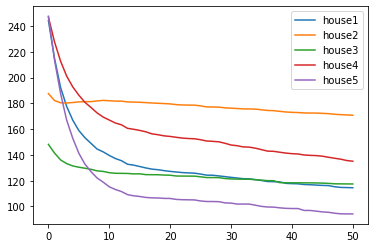

In [10]:
df1=pd.DataFrame(booster4.worker_trace,columns=["house1","house2","house3","house4","house5"])
df1.plot()

In [14]:
%%time
worker0="127.0.0.1:51912"
worker1="127.0.0.1:51908"
worker2="127.0.0.1:51911"
#workers=[worker0,worker1,worker2]
workers=[worker0,worker1,worker2]
booster0=DaskBooster(9, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=500, maxdepth=10)
trainfile1 = "F:/NILM/training_data/dishwasher_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/dishwasher_house_3_training_.csv"
trainfile0="F:/NILM/training_data/dishwasher_test_.csv"
# trainfile1="F:/NILM/ukdale_training/microwave_house_1_training_.csv"
# trainfile2="F:/NILM/ukdale_training/microwave_house_2_training_.csv"

#         worker0="127.0.0.1:54134"
#         worker1="127.0.0.1:54128"
#         worker2="127.0.0.1:54131"
        # worker3="127.0.0.1:53730"

fileList=[trainfile0, trainfile1, trainfile2]
#fileList=[trainfile1, trainfile2]
booster0.fit(fileList)

c:\users\chang\appdata\local\programs\python\python37\lib\site-packages\distributed\worker.py:3460: UserWarning: Large object of size 3.15 MB detected in task graph: 
  (        342.6057142857143       0.0
0             ...  x 2 columns],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


start the tree0:  0
converage loss is: 13.442498922841446
start the tree0:  1
converage loss is: 12.716536715553424
start the tree0:  2
converage loss is: 12.149647950491149
start the tree0:  3
converage loss is: 11.688424217453989
start the tree0:  4
converage loss is: 11.262801878431219
start the tree0:  5
converage loss is: 10.87465695072734
start the tree0:  6
converage loss is: 10.597199310906822
start the tree0:  7
converage loss is: 10.379242107817122
start the tree0:  8
converage loss is: 10.156055993483744
start the tree0:  9
converage loss is: 10.011282351520704
start the tree0:  10
converage loss is: 9.846129797781249
start the tree0:  11
converage loss is: 9.749382766613712
start the tree0:  12
converage loss is: 9.622591810978205
start the tree0:  13
converage loss is: 9.44956632269623
start the tree0:  14
converage loss is: 9.313393269042086
start the tree0:  15
converage loss is: 9.21478843048232
start the tree0:  16
converage loss is: 9.144164520188566
start the tree0: 

In [15]:
%%time
worker0="127.0.0.1:51912"
worker1="127.0.0.1:51908"
worker2="127.0.0.1:51911"
#workers=[worker0,worker1,worker2]
workers=[worker0,worker1,worker2]
booster1=DaskBooster(9, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=500, maxdepth=10)
trainfile1 = "F:/NILM/training_data/fridge_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/fridge_house_3_training_.csv"
trainfile0="F:/NILM/training_data/fridge_test_.csv"
# trainfile1="F:/NILM/ukdale_training/microwave_house_1_training_.csv"
# trainfile2="F:/NILM/ukdale_training/microwave_house_2_training_.csv"

#         worker0="127.0.0.1:54134"
#         worker1="127.0.0.1:54128"
#         worker2="127.0.0.1:54131"
        # worker3="127.0.0.1:53730"

fileList=[trainfile0, trainfile1, trainfile2]
#fileList=[trainfile1, trainfile2]
booster1.fit(fileList)

start the tree0:  0
converage loss is: 50.70611355026956
start the tree0:  1
converage loss is: 44.941152931552935
start the tree0:  2
converage loss is: 40.47408285012296
start the tree0:  3
converage loss is: 37.054024271259486
start the tree0:  4
converage loss is: 34.41542091737267
start the tree0:  5
converage loss is: 32.428668157840825
start the tree0:  6
converage loss is: 30.863168106869153
start the tree0:  7
converage loss is: 29.666964463165268
start the tree0:  8
converage loss is: 28.748545012047018
start the tree0:  9
converage loss is: 28.046111783514984
start the tree0:  10
converage loss is: 27.52038240826366
start the tree0:  11
converage loss is: 27.19554315207147
start the tree0:  12
converage loss is: 26.77438887882428
start the tree0:  13
converage loss is: 26.457062301982432
start the tree0:  14
converage loss is: 26.176498266864538
start the tree0:  15
converage loss is: 26.017776589225065
start the tree0:  16
converage loss is: 25.791746256234717
start the tre

In [16]:
%%time
worker0="127.0.0.1:51912"
worker1="127.0.0.1:51908"
worker2="127.0.0.1:51911"
#workers=[worker0,worker1,worker2]
workers=[worker0,worker1,worker2]
booster2=DaskBooster(9, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=500, maxdepth=10)
trainfile1 = "F:/NILM/training_data/washingmachine_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/washingmachine_house_3_training_.csv"
trainfile0="F:/NILM/training_data/washingmachine_test_.csv"
# trainfile1="F:/NILM/ukdale_training/microwave_house_1_training_.csv"
# trainfile2="F:/NILM/ukdale_training/microwave_house_2_training_.csv"

#         worker0="127.0.0.1:54134"
#         worker1="127.0.0.1:54128"
#         worker2="127.0.0.1:54131"
        # worker3="127.0.0.1:53730"

fileList=[trainfile0, trainfile1, trainfile2]
#fileList=[trainfile1, trainfile2]
booster2.fit(fileList)

start the tree0:  0
converage loss is: 19.68220698853229
start the tree0:  1
converage loss is: 15.580413395821376
start the tree0:  2
converage loss is: 12.424658974842847
start the tree0:  3
converage loss is: 10.005945424283608
start the tree0:  4
converage loss is: 8.171088923369796
start the tree0:  5
converage loss is: 6.717232355165304
start the tree0:  6
converage loss is: 5.616247694896333
start the tree0:  7
converage loss is: 4.783923158569914
start the tree0:  8
converage loss is: 4.14162938190776
start the tree0:  9
converage loss is: 3.632514844610641
start the tree0:  10
converage loss is: 3.246431545218304
start the tree0:  11
converage loss is: 2.9641145210813167
start the tree0:  12
converage loss is: 2.72558639409693
start the tree0:  13
converage loss is: 2.5557742844653655
start the tree0:  14
converage loss is: 2.4141834235026214
start the tree0:  15
converage loss is: 2.3152787968501087
start the tree0:  16
converage loss is: 2.2299518021146483
start the tree0:  

In [17]:
%%time
worker0="127.0.0.1:51912"
worker1="127.0.0.1:51908"
worker2="127.0.0.1:51911"
#workers=[worker0,worker1,worker2]
workers=[worker0,worker1,worker2]
booster3=DaskBooster(9, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=500, maxdepth=10)
trainfile1 = "F:/NILM/training_data/microwave_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/microwave_house_3_training_.csv"
trainfile0="F:/NILM/training_data/microwave_test_.csv"
# trainfile1="F:/NILM/ukdale_training/microwave_house_1_training_.csv"
# trainfile2="F:/NILM/ukdale_training/microwave_house_2_training_.csv"

#         worker0="127.0.0.1:54134"
#         worker1="127.0.0.1:54128"
#         worker2="127.0.0.1:54131"
        # worker3="127.0.0.1:53730"

fileList=[trainfile0, trainfile1, trainfile2]
#fileList=[trainfile1, trainfile2]
booster3.fit(fileList)

start the tree0:  0
converage loss is: 13.718510122648924
start the tree0:  1
converage loss is: 12.370372616705943
start the tree0:  2
converage loss is: 11.521474820005194
start the tree0:  3
converage loss is: 10.924994070667044
start the tree0:  4
converage loss is: 10.49012473173604
start the tree0:  5
converage loss is: 10.054554133488272
start the tree0:  6
converage loss is: 9.651600249139047
start the tree0:  7
converage loss is: 9.423627465195437
start the tree0:  8
converage loss is: 9.178595379468398
start the tree0:  9
converage loss is: 8.856992073828987
start the tree0:  10
converage loss is: 8.716842253249176
start the tree0:  11
converage loss is: 8.512647135027237
start the tree0:  12
converage loss is: 8.390075397456684
start the tree0:  13
converage loss is: 8.26161963570865
start the tree0:  14
converage loss is: 8.17689059802859
start the tree0:  15
converage loss is: 8.06335302233501
start the tree0:  16
converage loss is: 7.93412655081162
start the tree0:  17
co

<AxesSubplot:>

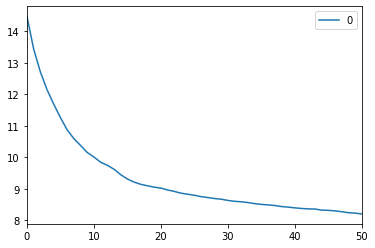

In [35]:
df=pd.DataFrame(booster0.trace)
df.plot()

<AxesSubplot:>

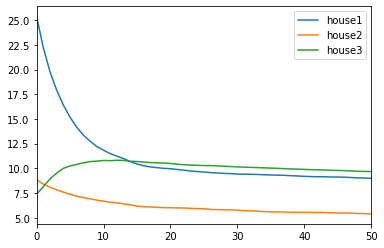

In [31]:
df0=pd.DataFrame(booster0.worker_trace, columns=["house1","house2","house3"])
df0.plot()

In [38]:
dtest=pd.DataFrame(booster0.worker_trace, columns=["house1","house2","house3"])
dtest.shape

(51, 3)

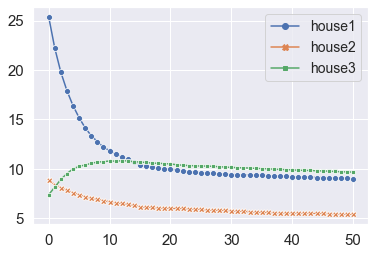

In [49]:
import seaborn as sns; #sns.set()
ax1=sns.lineplot(err_style="bars",  markers=True, dashes=False, data=dtest)
#ax1.grid()
ax1.legend(prop={'size': 14})
plt.tick_params(labelsize=15)
plt.show()

<AxesSubplot:>

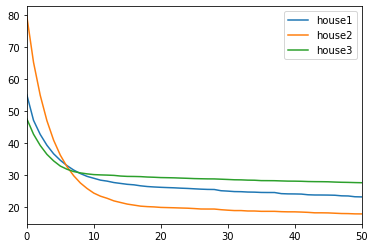

In [32]:
df1=pd.DataFrame(booster1.worker_trace,columns=["house1","house2","house3"])
df1.plot()

<AxesSubplot:>

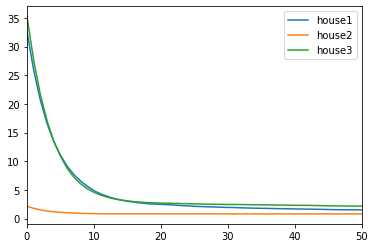

In [33]:
df2=pd.DataFrame(booster2.worker_trace,columns=["house1","house2","house3"])
df2.plot()

<AxesSubplot:>

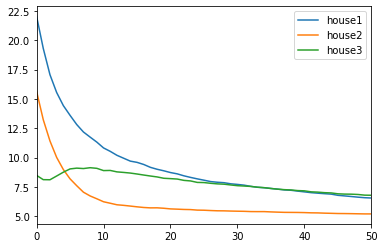

In [34]:
df3=pd.DataFrame(booster3.worker_trace,columns=["house1","house2","house3"])
df3.plot()

In [55]:
booster0.client=None
booster1.client=None
booster2.client=None
booster3.client=None
model0='F:/NILM/BuildSYS/REDD_dask/dishwasher.pkl'
with open(model0, 'wb+') as f:
    boost= pickle.dump(booster0, f)
model1='F:/NILM/BuildSYS/REDD_dask/fridge.pkl'
with open(model1, 'wb+') as f:
    boost= pickle.dump(booster1, f)
model2='F:/NILM/BuildSYS/REDD_dask/washingmachine.pkl'  
with open(model2, 'wb+') as f:
    boost= pickle.dump(booster2, f)
model3='F:/NILM/BuildSYS/REDD_dask/microwave.pkl'   
with open(model3, 'wb+') as f:
    boost= pickle.dump(booster3, f)

In [60]:
booster0.client=None
model0='F:/NILM/BuildSYS/REDD_dask/dishwasher.pkl'
with open(model0, 'rb+') as f:
    boostest= pickle.load(f)
boostest.ensemble

[{9: {'<=1195.15625': {9: {'<=905.72': {9: {'<=477.0750000000001': {9: {'<=372.3525': {9: {'<=281.66125': {6: {'<=106.27625': {9: {'<=108.575': {11: {'<=32.260000000000005': 2.1527275541870554,
                 '>32.260000000000005': {14: {'<=1145.7399999999998': {9: {'<=33.471250000000005': {17: {'<=33.15750000000001': 0.23675736332520828,
                       '>33.15750000000001': 0.8874276443937669}},
                     '>33.471250000000005': {14: {'<=91.25166666666668': 0.08465263692737915,
                       '>91.25166666666668': 0.014083479435946003}}}},
                   '>1145.7399999999998': 1.5744052424228325}}}},
               '>108.575': {17: {'<=289.83125': {1: {'<=106.32375': {9: {'<=233.77625': 0.03627857878225199,
                     '>233.77625': 0.14867217166680088}},
                   '>106.32375': 10.528969164843058}},
                 '>289.83125': 10.614161813840113}}}},
             '>106.27625': {5: {'<=286.2425': {6: {'<=164.00125': {0: {'<=93.82': 

In [23]:
trainfile1 = "F:/NILM/training_data/dishwasher_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/dishwasher_house_3_training_.csv"
testfile="F:/NILM/training_data/dishwasher_test_.csv"
X, Y = dataProvider(testfile, trainfile1, trainfile2, windowsize=19)
x_train_all, x_predict, y_train_all, y_predict = train_test_split(X, Y, test_size=0.2, random_state=100)
prediction=booster.predict(x_predict)
mae=mean_absolute_error(y_predict, prediction)
mae

9.047531425118484

In [22]:
def dataProvider(train1, train2, train3,windowsize):
    offset = int(0.5 * (windowsize - 1.0))
    data_frame1 = pd.read_csv(train1,
                             #chunksize=10 ** 3,
                             header=0
                             )
    data_frame2 = pd.read_csv(train2,
                             #chunksize=10 ** 3,
                             header=0
                             )
    data_frame3 = pd.read_csv(train3,
                             #chunksize=10 ** 3,
                             header=0
                             )

    np_array = np.array(data_frame1)
    inputs, targets = np_array[:, 0], np_array[:, 1]
    window_num=inputs.size - 2 * offset
    features=list()
    labels=list()
    for i in range(0,window_num):
        inp=inputs[i:i+windowsize]
        tar=targets[i+offset]
        features.append(inp)
        labels.append(tar)
    features0=np.array(features)
    labels0=np.array(labels)

    np_array = np.array(data_frame2)
    inputs, targets = np_array[:, 0], np_array[:, 1]
    window_num=inputs.size - 2 * offset
    features=list()
    labels=list()
    for i in range(0,window_num):
        inp=inputs[i:i+windowsize]
        tar=targets[i+offset]
        features.append(inp)
        labels.append(tar)
    features1=np.array(features)
    labels1=np.array(labels)

    np_array = np.array(data_frame3)
    inputs, targets = np_array[:, 0], np_array[:, 1]
    window_num=inputs.size - 2 * offset
    features=list()
    labels=list()
    for i in range(0,window_num):
        inp=inputs[i:i+windowsize]
        tar=targets[i+offset]
        features.append(inp)
        labels.append(tar)
    features2=np.array(features)
    labels2=np.array(labels)

    feature=np.concatenate((features0, features1), axis=0)
    feature=np.concatenate((feature, features2), axis=0)
    label=np.concatenate((labels0, labels1), axis=0)
    label=np.concatenate((label, labels2), axis=0)
    return feature, label

In [38]:
import xgboost as xgb
trainfile1 = "F:/NILM/training_data/dishwasher_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/dishwasher_house_3_training_.csv"
testfile="F:/NILM/training_data/dishwasher_test_.csv"
# X, Y = dataProvider(testfile, trainfile1, trainfile2, windowsize=19)
# x_train_all, x_predict, y_train_all, y_predict = train_test_split(X, Y, test_size=0.2, random_state=100)
# x_train, x_test, y_train, y_test = train_test_split(x_train_all, y_train_all, test_size=0.2,random_state=100)
model=xgb.XGBRegressor(max_depth=10, learning_rate=0.3,verbosity=2, n_estimators=50,objective='reg:squarederror', booster='gbtree', n_jobs=4, subsample=0.7, colsample_bytree=0.7 )
train=(x_train, y_train)
test=(x_test, y_test)
model.fit(x_train, y_train, eval_metric=['mae'],eval_set=[train, test], verbose=True, early_stopping_rounds=10,callbacks=None)

[12:09:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 524 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-mae:6.96068	validation_1-mae:7.53631
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 10 rounds.
[12:09:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 618 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-mae:5.29380	validation_1-mae:6.02887
[12:09:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 526 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-mae:4.12880	validation_1-mae:4.99552
[12:09:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 574 extra nodes, 0 pruned nodes, max_de

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.3, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=None,
             validate_parameters=False, verbosity=2)

In [31]:
prediction=model.predict(x_predict)
mae=mean_absolute_error(y_predict, prediction)
mae

9.072117653779127

In [37]:
dtrain = lgb.Dataset(x_train, y_train)
dtest = lgb.Dataset(x_test, y_test)
params = {
        'boosting': 'dart',
        'objective': 'regression',
        'metric': {'l1', 'l2'},
        'num_leaves': 1000,
        # 'num_leaves': 2,
        'min_data_in_leaf': 200,
        'max_depth': 10,
        'learning_rate': 0.23179,
        # 'feature_fraction':argsDict['feature_fraction'],
        # 'bagging_fraction': argsDict['bagging_fraction'],
        # 'bagging_freq': argsDict['bagging_freq'],
        'max_bin':1000,
        # 'num_boost_round':argsDict['num_boost_rount'] ,
        'min_data_in_bin': 100,
        'lambda_l2': 0,
        'lambda_l1': 0.7145,
        'verbose': -1,
        'is_provide_training_metric': True,
        # 'bin_construct_sample_cnt': 59139
}
gbm = lgb.train(params, dtrain, num_boost_round=50, valid_sets=dtest, early_stopping_rounds=10)

[1]	valid_0's l2: 6805.31	valid_0's l1: 15.1541


c:\users\chang\appdata\local\programs\python\python37\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	valid_0's l2: 5118.43	valid_0's l1: 13.1023
[3]	valid_0's l2: 3821.29	valid_0's l1: 11.2867
[4]	valid_0's l2: 3135.8	valid_0's l1: 9.994
[5]	valid_0's l2: 2609.56	valid_0's l1: 8.86129
[6]	valid_0's l2: 2301.57	valid_0's l1: 8.01152
[7]	valid_0's l2: 2105.66	valid_0's l1: 7.32926
[8]	valid_0's l2: 2249.15	valid_0's l1: 7.91303
[9]	valid_0's l2: 2068.63	valid_0's l1: 7.26244
[10]	valid_0's l2: 1901.14	valid_0's l1: 6.72762
[11]	valid_0's l2: 1801.38	valid_0's l1: 6.32225
[12]	valid_0's l2: 1844.51	valid_0's l1: 6.60967
[13]	valid_0's l2: 1754.81	valid_0's l1: 6.21056
[14]	valid_0's l2: 1704.99	valid_0's l1: 5.98628
[15]	valid_0's l2: 1670.67	valid_0's l1: 5.74473
[16]	valid_0's l2: 1637.43	valid_0's l1: 5.60517
[17]	valid_0's l2: 1616.79	valid_0's l1: 5.5307
[18]	valid_0's l2: 1584.26	valid_0's l1: 5.45083
[19]	valid_0's l2: 1560.49	valid_0's l1: 5.39799
[20]	valid_0's l2: 1537.85	valid_0's l1: 5.31558
[21]	valid_0's l2: 1541.27	valid_0's l1: 5.41509
[22]	valid_0's l2: 1517.91	valid

In [33]:
prediction=gbm.predict(x_predict)
mae=mean_absolute_error(y_predict, prediction)
mae

11.770448236641053

In [50]:
trainfile1 = "F:/NILM/training_data/dishwasher_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/dishwasher_house_3_training_.csv"
testfile="F:/NILM/training_data/dishwasher_test_.csv"
data_frame1 = pd.read_csv(trainfile1,
                             #chunksize=10 ** 3,
                             header=0
                             )
data_frame2 = pd.read_csv(trainfile2,
                             #chunksize=10 ** 3,
                             header=0
                             )
data_frame3 = pd.read_csv(testfile,
                             #chunksize=10 ** 3,
                             header=0
                             )
x_train1, y_train1, x_predict1, y_predict1, x_test1,  y_test1=EMDpreprocess(data_frame1)
x_train2, y_train2, x_predict2, y_predict2, x_test2,  y_test2=EMDpreprocess(data_frame2)
x_train3, y_train3, x_predict3, y_predict3, x_test3,  y_test3=EMDpreprocess(data_frame3)

In [51]:
dtrain1 = lgb.Dataset(x_train1, y_train1)
dtest1 = lgb.Dataset(x_test1, y_test1)
params = {
        'boosting': 'dart',
        'objective': 'regression',
        'metric': {'l1', 'l2'},
        'num_leaves': 1000,
        # 'num_leaves': 2,
        'min_data_in_leaf': 200,
        'max_depth': 10,
        'learning_rate': 0.23179,
        # 'feature_fraction':argsDict['feature_fraction'],
        # 'bagging_fraction': argsDict['bagging_fraction'],
        # 'bagging_freq': argsDict['bagging_freq'],
        'max_bin':500,
        # 'num_boost_round':argsDict['num_boost_rount'] ,
        'min_data_in_bin': 100,
        'lambda_l2': 0,
        'lambda_l1': 0.7145,
        'verbose': -1,
        'is_provide_training_metric': True,
        # 'bin_construct_sample_cnt': 59139
}
gbm1 = lgb.train(params, dtrain1, num_boost_round=50, valid_sets=dtest1, early_stopping_rounds=10)

[1]	valid_0's l2: 6901.15	valid_0's l1: 15.2702


c:\users\chang\appdata\local\programs\python\python37\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	valid_0's l2: 5143.54	valid_0's l1: 13.2104
[3]	valid_0's l2: 3938.54	valid_0's l1: 11.5466
[4]	valid_0's l2: 3306.79	valid_0's l1: 10.2995
[5]	valid_0's l2: 2714.83	valid_0's l1: 9.18232
[6]	valid_0's l2: 2346.25	valid_0's l1: 8.36301
[7]	valid_0's l2: 2100.82	valid_0's l1: 7.71702
[8]	valid_0's l2: 2264	valid_0's l1: 8.27616
[9]	valid_0's l2: 2066.22	valid_0's l1: 7.63454
[10]	valid_0's l2: 1920.06	valid_0's l1: 7.14508
[11]	valid_0's l2: 1808.1	valid_0's l1: 6.75475
[12]	valid_0's l2: 1867.6	valid_0's l1: 7.00741
[13]	valid_0's l2: 1813.64	valid_0's l1: 6.67135
[14]	valid_0's l2: 1739.29	valid_0's l1: 6.37059
[15]	valid_0's l2: 1691.17	valid_0's l1: 6.18515
[16]	valid_0's l2: 1639.86	valid_0's l1: 5.96932
[17]	valid_0's l2: 1612.88	valid_0's l1: 5.78832
[18]	valid_0's l2: 1588.02	valid_0's l1: 5.71163
[19]	valid_0's l2: 1566.94	valid_0's l1: 5.66124
[20]	valid_0's l2: 1554.66	valid_0's l1: 5.57509
[21]	valid_0's l2: 1560.48	valid_0's l1: 5.6787
[22]	valid_0's l2: 1544.31	valid_0

In [52]:
dtrain2 = lgb.Dataset(x_train2, y_train2)
dtest2 = lgb.Dataset(x_test2, y_test2)
params = {
        'boosting': 'dart',
        'objective': 'regression',
        'metric': {'l1', 'l2'},
        'num_leaves': 1000,
        # 'num_leaves': 2,
        'min_data_in_leaf': 200,
        'max_depth': 10,
        'learning_rate': 0.23179,
        # 'feature_fraction':argsDict['feature_fraction'],
        # 'bagging_fraction': argsDict['bagging_fraction'],
        # 'bagging_freq': argsDict['bagging_freq'],
        'max_bin':500,
        # 'num_boost_round':argsDict['num_boost_rount'] ,
        'min_data_in_bin': 100,
        'lambda_l2': 0,
        'lambda_l1': 0.7145,
        'verbose': -1,
        'is_provide_training_metric': True,
        # 'bin_construct_sample_cnt': 59139
}
gbm2 = lgb.train(params, dtrain2, num_boost_round=50, valid_sets=dtest2, early_stopping_rounds=10)

[1]	valid_0's l2: 3727.6	valid_0's l1: 12.0128
[2]	valid_0's l2: 3322.25	valid_0's l1: 11.2604
[3]	valid_0's l2: 3054.36	valid_0's l1: 10.639
[4]	valid_0's l2: 2858.52	valid_0's l1: 10.1608
[5]	valid_0's l2: 2720.46	valid_0's l1: 9.79838
[6]	valid_0's l2: 2622.79	valid_0's l1: 9.51578
[7]	valid_0's l2: 2555.2	valid_0's l1: 9.34908
[8]	valid_0's l2: 2596.83	valid_0's l1: 9.51609
[9]	valid_0's l2: 2536.17	valid_0's l1: 9.31812
[10]	valid_0's l2: 2479.87	valid_0's l1: 9.17147
[11]	valid_0's l2: 2432.78	valid_0's l1: 9.04326
[12]	valid_0's l2: 2449.92	valid_0's l1: 9.0996
[13]	valid_0's l2: 2408.23	valid_0's l1: 8.98091
[14]	valid_0's l2: 2376.07	valid_0's l1: 8.90431
[15]	valid_0's l2: 2349.49	valid_0's l1: 8.83083
[16]	valid_0's l2: 2331.92	valid_0's l1: 8.79871
[17]	valid_0's l2: 2317.2	valid_0's l1: 8.77287
[18]	valid_0's l2: 2300.98	valid_0's l1: 8.71235
[19]	valid_0's l2: 2273.27	valid_0's l1: 8.70132
[20]	valid_0's l2: 2261.84	valid_0's l1: 8.69379
[21]	valid_0's l2: 2263.4	valid_0'

In [53]:
dtrain3 = lgb.Dataset(x_train3, y_train3)
dtest3 = lgb.Dataset(x_test3, y_test3)
params = {
        'boosting': 'dart',
        'objective': 'regression',
        'metric': {'l1', 'l2'},
        'num_leaves': 1000,
        # 'num_leaves': 2,
        'min_data_in_leaf': 200,
        'max_depth': 10,
        'learning_rate': 0.23179,
        # 'feature_fraction':argsDict['feature_fraction'],
        # 'bagging_fraction': argsDict['bagging_fraction'],
        # 'bagging_freq': argsDict['bagging_freq'],
        'max_bin':500,
        # 'num_boost_round':argsDict['num_boost_rount'] ,
        'min_data_in_bin': 100,
        'lambda_l2': 0,
        'lambda_l1': 0.7145,
        'verbose': -1,
        'is_provide_training_metric': True,
        # 'bin_construct_sample_cnt': 59139
}
gbm3 = lgb.train(params, dtrain3, num_boost_round=50, valid_sets=dtest3, early_stopping_rounds=10)

[1]	valid_0's l2: 15305	valid_0's l1: 40.592
[2]	valid_0's l2: 10699.1	valid_0's l1: 34.2694
[3]	valid_0's l2: 7962.17	valid_0's l1: 29.4083
[4]	valid_0's l2: 6320.86	valid_0's l1: 25.6091
[5]	valid_0's l2: 5336.23	valid_0's l1: 22.6302
[6]	valid_0's l2: 4743.92	valid_0's l1: 20.423
[7]	valid_0's l2: 4389.22	valid_0's l1: 18.6865
[8]	valid_0's l2: 4715.05	valid_0's l1: 20.3847
[9]	valid_0's l2: 4370.51	valid_0's l1: 18.657
[10]	valid_0's l2: 4155.21	valid_0's l1: 17.3319
[11]	valid_0's l2: 4000.29	valid_0's l1: 16.2573
[12]	valid_0's l2: 4085.22	valid_0's l1: 16.9934
[13]	valid_0's l2: 3940.18	valid_0's l1: 16.0151
[14]	valid_0's l2: 3850.26	valid_0's l1: 15.2032
[15]	valid_0's l2: 3804.43	valid_0's l1: 14.6199
[16]	valid_0's l2: 3758.49	valid_0's l1: 14.1835
[17]	valid_0's l2: 3703.16	valid_0's l1: 13.7917
[18]	valid_0's l2: 3677.99	valid_0's l1: 13.5355
[19]	valid_0's l2: 3654.24	valid_0's l1: 13.3392
[20]	valid_0's l2: 3631.54	valid_0's l1: 13.2431
[21]	valid_0's l2: 3626.57	valid_0

In [54]:
prediction1=gbm1.predict(x_predict1)
prediction2=gbm2.predict(x_predict2)
prediction3=gbm3.predict(x_predict3)
prediction=np.concatenate([prediction1, prediction2, prediction3])
y_predict=np.concatenate([y_predict1,y_predict2,y_predict3])
mae=mean_absolute_error(y_predict, prediction)
mae

9.172544105169584